<a href="https://colab.research.google.com/github/viniciusrpb/cic0269_natural_language_processing/blob/main/lectures/cap11_2_cnn_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capítulo 11 - Redes Neurais Convolucionais

## 11.2 - Implementando uma AlexNet para Classificação de Imagens de Documentos

A AlexNet é uma arquitetura rede neural convolucional profunda desenvolvida em 2012 para a tradicional competição de classificação e reconhecimento de imagens ImageNet.

Você pode consultar o artigo da AlexNet [aqui](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf).

A arquitetura da AlexNet é representada graficamente pela seguinte figura:

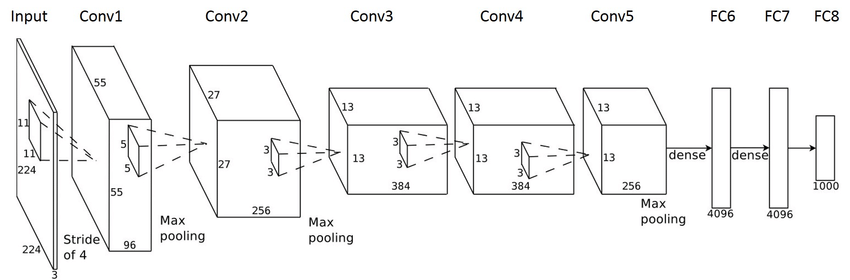

Informações sobre a coleção de imagens utilizada. É uma amostragem aleatória do conjunto

In [1]:
#!pip install -U keras
#!pip install tensorflow

### Leitura das imagens

Fazer o carregamento de coleções de imagens que estão já carregadas dentro do Keras-tensorflow é tranquilo, vide o [Cifar-10 (recomendo ver este link)](https://keras.io/api/datasets/cifar10/). E quando temos e queremos processar nossas próprias imagens? Aí é um pouco mais difícil, mas não impossível!

Para viabilizar o carregamento das imagens em uma estrutura que permita ler as imagens do disco e processá-las pelos objetos do Keras-tensorflow, vamos utilizar a classe [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Os principais motivos dessa escolha são:

*   Facilidade de se carregar imagens diretamente do disco ou por DataFrames;
*   Facilidade de utilizar operações de pré-processamento (normalização, reescalonamento etc) e que podem ser úteis em uma etapa conhecida como DataAugmentation (veremos adiante)!

### Organizando os arquivos das imagens

A pasta principal da coleção de imagens possui nome "documents". Dentro dessa pasta existem três subpastas, cada uma associada com uma label:

*   documents
    + advertisement
    + email
    + scientific paper

Nesse notebook, teremos que dividir a coleção de imagens em sub-partes (treinamento, validação e testes) utilizando a técnica Holdout. Essa técnica foi escolhida pela sua simplicidade e para facilitar a codificação na sala de aula. Entretanto, recomenda-se o uso da técnica [Stratified K-Fold Cross Validation](lectures/cap08_2_avaliacao_desempenho.ipynb) para avaliação do desempenho da classificação, visto que essa abordagem retorna resultados menos enviesados em relação à amostragem realizada para obter a divisão treinamento-validação-teste e que evita risco de supertreinamento *overfitting*.

Supondo que a pasta "documents" esteja no Google Drive, vamos montar o drive e copiar a pasta para o ambiente no Colab:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/ocr/full_3/' 'documents'

Fazendo-se os imports necessários:

In [4]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Leitura de dados

In [5]:
path_documents = 'documents'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
    lista_imagens = os.listdir(path_documents+'/'+folder)

    for img_file in lista_imagens:
        dataset_dict['filename'].append(folder+'/'+img_file)
        dataset_dict['label'].append(folder)

In [6]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])
df.sample(frac=1)

,filename,label
1014,email/2073085598a.tif,email
1604,email/6449.tif,email
245,advertisement/3246.tif,advertisement
2595,scientific _publication/10417856.tif,scientific _publication
1056,email/2085116518.tif,email
...,...,...
2477,scientific _publication/1005092826_1005092867.tif,scientific _publication
2653,scientific _publication/5999.tif,scientific _publication
1787,email/6911.tif,email
1851,email/2085177886b.tif,email


In [7]:
X = df['filename'].values
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

Criação dos logits dos labels

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)

y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes

y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [10]:
lista_train = []
for i in range(0,len(X_train)):
    lista_train.append([X_train[i],y_train[i]])

lista_valid = []
for i in range(0,len(X_valid)):
    lista_valid.append([X_valid[i],y_valid[i]])

lista_test = []
for i in range(0,len(X_test)):
    lista_test.append([X_test[i],y_test[i]])

In [11]:
df_train = pd.DataFrame(lista_train,columns = ['filename','label'])
df_valid = pd.DataFrame(lista_valid,columns = ['filename','label'])
df_test = pd.DataFrame(lista_test,columns = ['filename','label'])

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',
                                              shuffle=False)


Found 2072 validated image filenames belonging to 3 classes.
Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


Hyperparameters

In [13]:
dims = (224,224,3)
num_classes = 3
lr = 0.00002

In [14]:
model = Sequential()
# Parte 1 da AlexNet
model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96,(11,11), strides=(4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))

# Parte 2 da AlexNet
model.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))

# Parte 3 da AlexNet
model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dense(4096))
model.add(Activation("relu"))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0         
                                                        

In [16]:
sgd = SGD(learning_rate=lr)

model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine = model.fit(train_generator,
                        epochs=50,
                        batch_size=64,
                        validation_data=valid_generator)

Epoch 1/50
65/65 [==============================] - 25s 179ms/step - loss: 1.0992 - accuracy: 0.3277 - val_loss: 1.0997 - val_accuracy: 0.3211
Epoch 2/50
65/65 [==============================] - 10s 154ms/step - loss: 1.0989 - accuracy: 0.3277 - val_loss: 1.0994 - val_accuracy: 0.3211
Epoch 3/50
65/65 [==============================] - 10s 153ms/step - loss: 1.0986 - accuracy: 0.3277 - val_loss: 1.0990 - val_accuracy: 0.3211
Epoch 4/50
65/65 [==============================] - 10s 151ms/step - loss: 1.0982 - accuracy: 0.3277 - val_loss: 1.0987 - val_accuracy: 0.3211
Epoch 5/50
65/65 [==============================] - 10s 150ms/step - loss: 1.0979 - accuracy: 0.3277 - val_loss: 1.0984 - val_accuracy: 0.3211
Epoch 6/50
65/65 [==============================] - 10s 152ms/step - loss: 1.0976 - accuracy: 0.3277 - val_loss: 1.0980 - val_accuracy: 0.3211
Epoch 7/50
65/65 [==============================] - 10s 152ms/step - loss: 1.0973 - accuracy: 0.3277 - val_loss: 1.0977 - val_accuracy: 0.3211

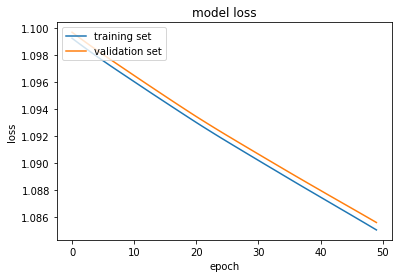

In [17]:
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

Analisando-se os resultados finais com as imagens de teste:

In [18]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [19]:
y_test = test_generator.classes

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.14      0.25       188
           1       1.00      0.39      0.56       171
           2       0.39      0.99      0.56       175

    accuracy                           0.50       534
   macro avg       0.78      0.51      0.46       534
weighted avg       0.78      0.50      0.45       534



Bem ruim... tem como melhorar? Vamos adicionar as seguintes camadas Dropout e BatchNormalization:

In [21]:
model2 = Sequential()
# Parte 1 da AlexNet
model2.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model2.add(Conv2D(96,(11,11), strides=(4,4)))
model2.add(Activation("relu"))
model2.add(MaxPooling2D((3, 3),strides=(2,2)))
model2.add(BatchNormalization())

# Parte 2 da AlexNet
model2.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model2.add(Activation("relu"))
model2.add(MaxPooling2D((3, 3),strides=(2,2)))
model2.add(BatchNormalization())

# Parte 3 da AlexNet
model2.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())

model2.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model2.add(Activation("relu"))
model2.add(BatchNormalization())

model2.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model2.add(Activation("relu"))
model2.add(MaxPooling2D((3, 3),strides=(2,2)))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(4096))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())

model2.add(Dense(4096))
model2.add(Activation("relu"))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())

model2.add(Dense(num_classes))
model2.add(Activation("softmax"))

In [22]:
sgd = SGD(learning_rate=lr)

model2.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine = model2.fit(train_generator,
                        epochs=30,
                        batch_size=64,
                        validation_data=valid_generator)

Epoch 1/30
65/65 [==============================] - 12s 163ms/step - loss: 1.4476 - accuracy: 0.3793 - val_loss: 1.1069 - val_accuracy: 0.3465
Epoch 2/30
65/65 [==============================] - 9s 146ms/step - loss: 1.2065 - accuracy: 0.4759 - val_loss: 1.1466 - val_accuracy: 0.3465
Epoch 3/30
65/65 [==============================] - 10s 160ms/step - loss: 1.0725 - accuracy: 0.5502 - val_loss: 1.1793 - val_accuracy: 0.3831
Epoch 4/30
65/65 [==============================] - 10s 148ms/step - loss: 0.9569 - accuracy: 0.5917 - val_loss: 1.1494 - val_accuracy: 0.5070
Epoch 5/30
65/65 [==============================] - 10s 148ms/step - loss: 0.9182 - accuracy: 0.6028 - val_loss: 1.1076 - val_accuracy: 0.4789
Epoch 6/30
65/65 [==============================] - 10s 148ms/step - loss: 0.8510 - accuracy: 0.6501 - val_loss: 0.9445 - val_accuracy: 0.6056
Epoch 7/30
65/65 [==============================] - 10s 147ms/step - loss: 0.8499 - accuracy: 0.6347 - val_loss: 0.7982 - val_accuracy: 0.6704


Agora avaliando-se o modelo 2 com os dados de teste

In [23]:
y_prob = model2.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)
y_test = test_generator.classes
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84       188
           1       0.89      0.92      0.90       171
           2       0.80      0.86      0.83       175

    accuracy                           0.86       534
   macro avg       0.86      0.86      0.86       534
weighted avg       0.86      0.86      0.86       534



**Dicas de como ajustar os hiperparâmetros**:

*   Número de épocas: 
*   Batch size:
*   



Melhorou um pouco!

### Data Augmentation

Uma estratégia bem conhecida para aumentar a quantidade de dados de treinamento é a data augmentation. Nesse notebook, iremos abordar o uso do [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator), que pega uma imagem do treinamento e gera novas imagens após a aplicação de várias transformações afins e geométricas (veja a lista de transformações disponíveis na própria documentação).

Observação 1: De acordo com a documentação do ImageDataGenerator, as imagens originais não são incluídas nesse novo conjunto de imagens transformadas, nem são aproveitadas no treinamento.

Observação 2: **deve-se realizar data augmentation apenas nos dados de treinamento**! Os dados de validação e de teste devem permanecer conforme a amostragem realizada, uma vez que eles devem possuir a mesma distribuição estatística como ocorrem naturalmente.

Para isso, propomos a seguinte alteração nos objetos ImageDataGenerator:

*   train_datagen: um ImageDataGenerator específico para receber os dados de treinamento e que contém as transformações para a geração de novas imagens;
*   agnostic_datagen: um ImageDataGenerator que apenas recebe as imagens de validação e de treinamento, mas que serão armazenadas em fluxos distintos.



In [24]:
agnostic_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = agnostic_datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',shuffle=False)

test_generator = agnostic_datagen.flow_from_dataframe(df_test,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                             class_mode='categorical',shuffle=False)

Found 355 validated image filenames belonging to 3 classes.
Found 534 validated image filenames belonging to 3 classes.


In [25]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=[0.3, 1.5],
                                   brightness_range=[0.1, 1.5]
                                   )

train_generator = train_datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename',y_col='label',
                                              class_mode='categorical',
                                              shuffle=True)

Found 2072 validated image filenames belonging to 3 classes.


Vamos ver como fica

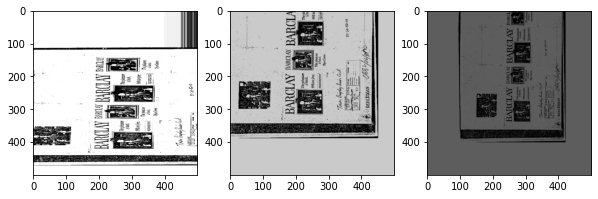

In [26]:
img = image.load_img('/content/documents/advertisement/0000126140.tif', target_size= (500,500))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

pic = train_datagen.flow(img_tensor, batch_size =1)
plt.figure(figsize=(10,8))
#Plots our figures
for i in range(1,4):
  plt.subplot(1, 3, i)
  batch = pic.next()
  img = 255*batch[0]
  image_ = img.astype('uint8')
  plt.imshow(image_)
plt.show()

In [27]:
model_aug = Sequential()
# Parte 1 da AlexNet
model_aug.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model_aug.add(Conv2D(96,(11,11), strides=(4,4)))
model_aug.add(Activation("relu"))
model_aug.add(MaxPooling2D((3, 3),strides=(2,2)))
model_aug.add(BatchNormalization())

# Parte 2 da AlexNet
model_aug.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model_aug.add(Activation("relu"))
model_aug.add(MaxPooling2D((3, 3),strides=(2,2)))
model_aug.add(BatchNormalization())

# Parte 3 da AlexNet
model_aug.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model_aug.add(Activation("relu"))

model_aug.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model_aug.add(Activation("relu"))

model_aug.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model_aug.add(Activation("relu"))

model_aug.add(MaxPooling2D((3, 3),strides=(2,2)))

model_aug.add(Flatten())

model_aug.add(Dense(4096))
model_aug.add(Activation("relu"))
model_aug.add(Dropout(0.5))
model_aug.add(BatchNormalization())

model_aug.add(Dense(4096))
model_aug.add(Activation("relu"))
model_aug.add(Dropout(0.5))
model_aug.add(BatchNormalization())

model_aug.add(Dense(num_classes))
model_aug.add(Activation("softmax"))

In [28]:
sgd = SGD(learning_rate=lr)

model_aug.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=['accuracy'])

history_fine = model_aug.fit(train_generator,
                        epochs=30,
                        batch_size=64,
                        validation_data=valid_generator)

Epoch 1/30
65/65 [==============================] - 39s 591ms/step - loss: 1.4015 - accuracy: 0.4083 - val_loss: 1.0997 - val_accuracy: 0.3465
Epoch 2/30
65/65 [==============================] - 39s 606ms/step - loss: 1.3107 - accuracy: 0.4319 - val_loss: 1.1185 - val_accuracy: 0.3465
Epoch 3/30
65/65 [==============================] - 38s 579ms/step - loss: 1.1424 - accuracy: 0.5048 - val_loss: 1.1324 - val_accuracy: 0.3465
Epoch 4/30
65/65 [==============================] - 37s 576ms/step - loss: 1.1521 - accuracy: 0.5039 - val_loss: 1.1286 - val_accuracy: 0.3493
Epoch 5/30
65/65 [==============================] - 39s 603ms/step - loss: 1.1056 - accuracy: 0.5232 - val_loss: 1.0799 - val_accuracy: 0.3690
Epoch 6/30
65/65 [==============================] - 37s 574ms/step - loss: 1.0647 - accuracy: 0.5526 - val_loss: 0.9405 - val_accuracy: 0.4817
Epoch 7/30
65/65 [==============================] - 39s 605ms/step - loss: 1.0613 - accuracy: 0.5555 - val_loss: 0.8024 - val_accuracy: 0.6732

In [29]:
y_prob = model_aug.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)
y_test = test_generator.classes
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       188
           1       0.90      0.80      0.85       171
           2       0.70      0.87      0.78       175

    accuracy                           0.81       534
   macro avg       0.83      0.81      0.82       534
weighted avg       0.83      0.81      0.82       534

